<a href="https://colab.research.google.com/github/ryan-avancena/476-cifar10/blob/main/cifar10_cnn_(pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # CIFAR-10 Classifier with CNN

 <hr>

## importing libraries

In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms

## preprocessing and retrieving data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:06<00:00, 27.5MB/s]


## for fun

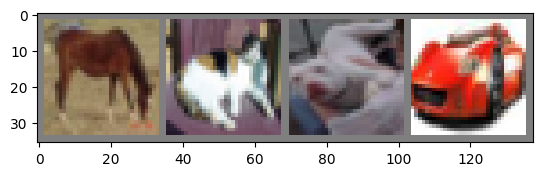

horse cat   dog   car  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    # print(npimg.shape)      # (3, 36, 138)
    # print(npimg)            # uncomment to see pixel values
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## defining the cnn

### layer by layer

```
torch.nn.Conv2d(
  in_channels,
  out_channels,
  kernel_size,
    stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None
  )
```

**Conv2d**
- **applies a 2D covolution over an input**
- first layer will have 3 channels, 6 feature maps, and a kernel size of 5x5
- stride=1 means we'll move 1 pixel at a time
- output: (input - kernel_size + 2*padding)/stride + 1 = (6,28,28)

<hr>

```
torch.nn.MaxPool2d(
  kernel_size,
  stride=None,
    padding=0, dilation=1, return_indices=False, ceil_mode=False
)
```

**MaxPool2d**
- **applies 2d max pooling over a n x n window**
- output: (input - kernel_size + 2*padding)/stride + 1 = (6,14,14)

<hr>

```
torch.nn.Linear(
  in_features,
  out_features,
  bias=True,
  device=None,
  dtype=None
)
```

Linear
- **applies a linear transformation to the incoming data (aka fully-connected layer)**
- output: (input - kernel_size + 2*padding)/stride + 1 = (10)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

""" layer by layer overview

torch.nn.Conv2d(
  in_channels,
  out_channels,
  kernel_size,
    stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None
  )

Conv2d: applies a 2d covolution over an input
- first layer will have 3 channels, 6 feature maps, and a kernel size of 5x5
- stride=1: move 1 pixel at a time
- output: (input - kernel_size + 2*padding)/stride + 1 = (6,28,28)

torch.nn.MaxPool2d(
  kernel_size,
  stride=None,
    padding=0, dilation=1, return_indices=False, ceil_mode=False
)

MaxPool2d: applies 2d max pooling over a nxn window
- output: (input - kernel_size + 2*padding)/stride + 1 = (6,14,14)

torch.nn.Linear(
  in_features,
  out_features,
  bias=True,
  device=None,
  dtype=None
)

Linear: applies a linear transformation to the incoming data aka fully-connected layer
- output: (input - kernel_size + 2*padding)/stride + 1 = (10)

"""

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*5*5,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## loss function

```
torch.nn.CrossEntropyLoss(
  weight=None,
  size_average=None,
  ignore_index=-100,
  reduce=None,
  reduction='mean',
  label_smoothing=0.0)
```

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## training our model

In [6]:
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader,0):
    inputs, labels = data
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.284
[1,  4000] loss: 2.006
[1,  6000] loss: 1.703
[1,  8000] loss: 1.612
[1, 10000] loss: 1.515
[1, 12000] loss: 1.493
[2,  2000] loss: 1.413
[2,  4000] loss: 1.368
[2,  6000] loss: 1.351
[2,  8000] loss: 1.337
[2, 10000] loss: 1.305
[2, 12000] loss: 1.269
Finished Training


## saving our model

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

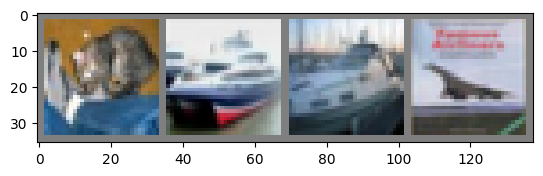

GroundTruth:  cat   ship  ship  plane
Predicted:  dog   car   plane ship 


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


In [10]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 61.1 %
Accuracy for class: car   is 82.6 %
Accuracy for class: bird  is 35.1 %
Accuracy for class: cat   is 12.1 %
Accuracy for class: deer  is 63.2 %
Accuracy for class: dog   is 60.9 %
Accuracy for class: frog  is 67.6 %
Accuracy for class: horse is 53.0 %
Accuracy for class: ship  is 64.8 %
Accuracy for class: truck is 46.9 %


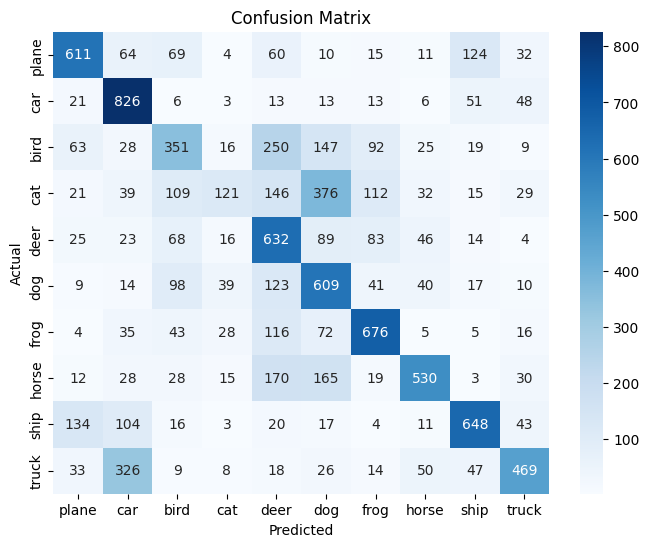

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Initialize variables
all_labels = []
all_predictions = []

# No gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        # Store predictions and labels for confusion matrix
        all_labels.extend(labels.numpy())  # Convert to NumPy array
        all_predictions.extend(predictions.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

del dataiter

cpu
